In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read the data

In [2]:
fname = 'monthly-car-sales'

In [3]:
df = pd.read_csv('data/'+fname+'.csv')
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [4]:
type(df)

pandas.core.frame.DataFrame

In [5]:
df = pd.read_csv('data/'+fname+'.csv', parse_dates=[df.columns[0]], index_col=[df.columns[0]])
df.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [6]:
type(df)

pandas.core.frame.DataFrame

## Resampling

In [7]:
ts = df[df.columns[0]].resample('MS').sum()
ts.head()

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Freq: MS, Name: Sales, dtype: int64

In [8]:
type(ts)

pandas.core.series.Series

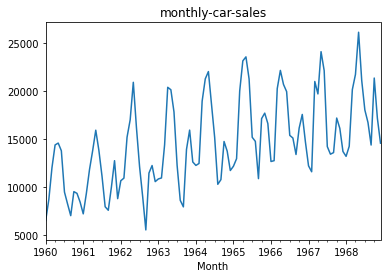

In [9]:
ts.plot()
plt.title(fname)
plt.savefig('saved/'+fname+'.jpg')

## Stationarity check

In [10]:
import statsmodels.api as sm

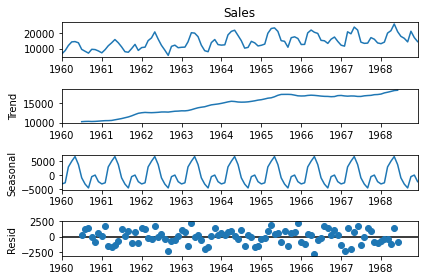

In [11]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
adftest = adfuller(ts)

In [14]:
adftest

(-1.2238127661752831,
 0.6632691049832871,
 12,
 95,
 {'1%': -3.5011373281819504,
  '5%': -2.8924800524857854,
  '10%': -2.5832749307479226},
 1671.1995896872572)

In [15]:
print('p-value of adfuller test is: ',adftest[1])

p-value of adfuller test is:  0.6632691049832871


https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

## Train-Test split

In [16]:
split_id = int(len(ts)/3)

In [17]:
2*split_id

72

In [18]:
train = ts[:2*split_id]
test = ts[2*split_id:]

<AxesSubplot:xlabel='Month'>

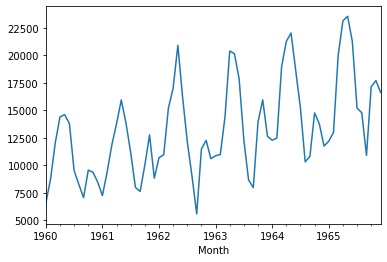

In [19]:
train.plot()

<AxesSubplot:xlabel='Month'>

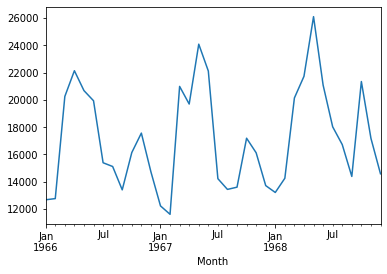

In [20]:
test.plot()

## ARIMA model building

### Setting hyperparameters

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [22]:
least_error = 999999
p_best, d_best, q_best = 0, 0, 0
for p in range(11):
    for d in range(3):
        for q in range(6):
            try:
                model = ARIMA(train,order=(p,d,q)).fit(method_kwargs={"warn_convergence": False})
                pred = model.predict(start=len(train),end=len(ts)-1,exog=None,dynamic=False)
                error = np.sqrt(mean_squared_error(test,pred))
                if error < least_error:
                    least_error = error
                    p_best, d_best, q_best = p, d, q
            except:
                continue

p, d, q = p_best, d_best, q_best

print('best model: p = {}, d = {}, q = {}'.format(p,d,q))
print('with error = ',least_error)

best model: p = 10, d = 1, q = 1
with error =  2137.792632442505


Other methods are using ACF for p and PACF for q

### Build ARIMA model

In [24]:
model = ARIMA(train,order=(p,d,q))

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
model_fit = model.fit()

In [27]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   72
Model:                ARIMA(10, 1, 1)   Log Likelihood                -635.404
Date:                Thu, 27 Jan 2022   AIC                           1294.809
Time:                        23:11:32   BIC                           1321.961
Sample:                    01-01-1960   HQIC                          1305.606
                         - 12-01-1965                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1971      0.281     -0.701      0.483      -0.748       0.354
ar.L2         -0.2208      0.139     -1.587      0.113      -0.493       0.052
ar.L3         -0.4989      0.100     -4.966      0.0

## Model evaluation

In [28]:
pred = model_fit.predict(start=len(train),end=len(ts)-1,exog=None,dynamic=False)

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
error = np.sqrt(mean_squared_error(test,pred))
error

2137.792632442505

In [31]:
test.mean(), np.sqrt(test.var())

(17179.472222222223, 3784.079465234094)

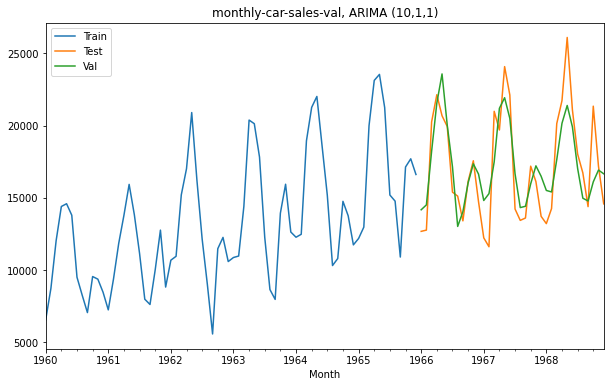

In [32]:
train.plot(label='Train', figsize=(10,6))
test.plot(label='Test')
pred.plot(label='Val')
plt.legend(loc = 'best')
plt.title(fname+'-val, ARIMA ({},{},{})'.format(p,d,q))
plt.savefig('saved/'+fname+'-val.jpg')

## Predict future data

In [36]:
final_model = ARIMA(ts,order=(p,d,q)).fit()

In [37]:
pred_final = final_model.predict(len(ts),len(ts)+50)

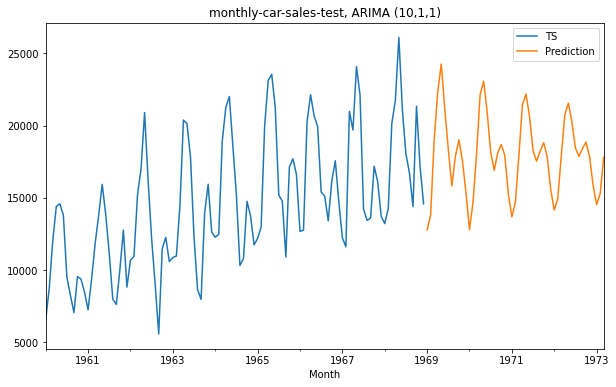

In [38]:
ts.plot(label='TS', figsize=(10,6))
pred_final.plot(label='Prediction')
plt.legend(loc = 'best')
plt.title(fname+'-test, ARIMA ({},{},{})'.format(p,d,q))
plt.savefig('saved/'+fname+'-test.jpg')

Found a (visually evaluated on predicted data) better hyperparameters

In [42]:
p, d, q = 10, 2, 4

In [43]:
better_model = ARIMA(df,order=(p,d,q)).fit()

In [44]:
pred_final = better_model.predict(len(ts),len(ts)+50)

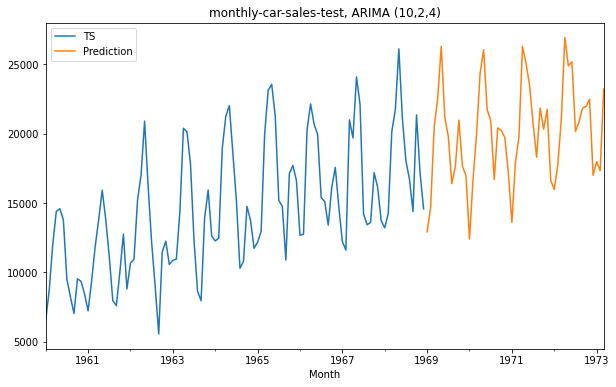

In [45]:
ts.plot(label='TS', figsize=(10,6))
pred_final.plot(label='Prediction')
plt.legend(loc = 'best')
plt.title(fname+'-test, ARIMA ({},{},{})'.format(p,d,q))
plt.savefig('saved/'+fname+'-test-better.jpg')